# Setup

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, fft
import math as math
import os
from matplotlib.patches import Polygon
import copy
import pickle
from scipy.stats import norm,wilcoxon,shapiro,ttest_rel
import statistics


In [2]:
# plotting parameters
#determine colors and font size|
colors = dict(M='#6600CC',
              F='#000000',
              B='#FFFFFF',
              H='#009900',
              r='#FDB119',
              u='#009900',
              u25='#BBF90F',
              u75='#006400',
              d='#FD6E19',
              #y='#0033FF',  #or 6600CC which is darker and I prefer 
              y='#6600CC',  #or 6600CC which is darker and I prefer 
              N='#0000CC',
              D='#CC0000',
              g='#B1B1B1', #grey
              first5='#B1B1B1',
              last5='#999999',
              BLUE = '#1f77b4',
              ORANGE = '#ff7f0e',
              GREEN = '#2ca02c',
              RED = '#d62728',
              PURPLE = '#9467bd',
              GOLD = '#FDB119') #default colors
              # D = dominant = right; N = nondominant = left

yfill = list(matplotlib.colors.to_rgba(colors['y']))
yfill[-1] = 0.3

ufill = list(matplotlib.colors.to_rgba(colors['u']))
ufill[-1] = 0.3

gfill = list(matplotlib.colors.to_rgba(colors['g']))
gfill[-1] = 0.3

rfill = list(matplotlib.colors.to_rgba(colors['r']))
rfill[-1] = 0.3

bfill = list(matplotlib.colors.to_rgba(colors['BLUE']))
bfill[-1] = 0.3

font = {#'family' : 'normal',
        # 'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [3]:
a_file = open("HCPS.pkl", "rb") #remember to close afterwards
HCPS = pickle.load(a_file)
a_file.close()

b_file = open("DATA.pkl", "rb") #remember to close afterwards
DATA = pickle.load(b_file)
b_file.close()

c_file = open("TF.pkl", "rb") #remember to close afterwards
TF = pickle.load(c_file)
c_file.close()

d_file = open("SIM.pkl", "rb") #remember to close afterwards
SIM = pickle.load(d_file)
d_file.close()

lqg_file = open("LQG_SIM.pkl", "rb") #remember to close afterwards
LQG_SIM = pickle.load(lqg_file)
lqg_file.close()

In [4]:
# Data analysis
def FFT(data,N):
  return fft.fft(data)/N

def IFFT(data,N):
  return (fft.ifft(data)*N).real
  
M = lambda s : 1/(s**2 + s) #2nd order machine

num_cond = 7 #number of conditions
participants_num = len(HCPS.keys())

#number of trials for each condition
trialnum = [0] * num_cond 
for c in range(num_cond):
  trialnum[c] = len(HCPS['subject0']['condition'+str(c)].keys())         #number of data trials, trial0 ~ trial3

#parameters (same for all three conditions)
fs = 60                               #pygame update rate 60 Hz
base_freq = 0.05                      #1/20 Hz
N = len(HCPS['subject0']['condition0']['trial0']['time_'])    #data length
xf_all = fft.fftfreq(N, 1./ fs)       #freq (x-axis) both + and - terms
xf = fft.fftfreq(N, 1./ fs)[:N//2]    #freq (x-axis) positive-frequency terms
M_h = M(1.j*2*np.pi*xf_all)           #M_hat = 1/ ((jw)^2 + (jw))
t = HCPS['subject0']['condition0']['trial0']['time_']         #time
prime = np.asarray([2, 3, 5, 7, 
                    11, 13, 17, 19])  #prime numbers
stimulated_index = prime*2 #array([ 4,  6, 10, 14, 22, 26, 34, 38])
stimulated_freq = prime*base_freq

T = 40 #final simulation time 
dt = 1/fs #time steps (60Hz) 
scaleOutputScreen = 1/4
scaleInput = 0.04616974606700115

<ipython-input-4-cf8719837387>:8: RuntimeWarning: divide by zero encountered in true_divide
  M = lambda s : 1/(s**2 + s) #2nd order machine
<ipython-input-4-cf8719837387>:8: RuntimeWarning: invalid value encountered in true_divide
  M = lambda s : 1/(s**2 + s) #2nd order machine


## plot functions

In [5]:
import textwrap
def wrap_labels(ax, width, my_labels, break_long_words=False):
    labels = []
    for label in my_labels:
        # text = label.get_text()
        labels.append(textwrap.fill(label, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

In [6]:
def BOXPLOT(data0, title0 ,data1 = None, title1 = None, ylimit0 = None, ylimit1= None, EMGplot = False, Sliderplot = False): # can plot one or two plots
    '''
    data0 and data1: list of 7 arrays, [cond0, cond1, ... cond6]
    '''
    
    # pos = np.array(range(num_cond))+1
    # xticks = pos
    # xticklabels = ['Slider','EMG','50%','25%','75%','Slider2','EMG2']
    # labels = [r'$1^{st}$$\alpha=0$   100:0',r'$1^{st}$$\alpha=1$   0:100',r'$\alpha=0.5$ 50:50',r'$\alpha=0.25$ 75:25',
    #             r'$\alpha=0.75$ 25:75',r'$2^{nd}$$\alpha=0$ 100:0',r'$2^{nd}$$\alpha=1$ 0:100'] #slider : EMG
    # labels = [r'$1^{st}$ $\alpha=0$',r'$1^{st}$ $\alpha=1$',r'$\alpha=0.5$',r'$\alpha=0.25$',
    #             r'$\alpha=0.75$',r'$2^{nd}$ $\alpha=0$',r'$2^{nd}$ $\alpha=1$'] #slider : EMG
    labels = ['100:0','0:100','50:50','75:25','25:75','100:0','0:100'] #slider : EMG
    # labels = [r'$1^{st}$ 100:0',r'$1^{st}$ 0:100',r'50:50',r'75:25',
                # r'25:75',r'$2^{nd}$ 100:0',r'$2^{nd}$ 0:100'] #slider : EMG
    boxcolors = ['white', 'black', 'darkgrey','lightgrey','dimgrey','white', 'black']
    # boxcolors = ['white', 'black', 'silver','whitesmoke','dimgrey','white', 'black']
    # boxcolors = ['white', 'black', 'limegreen','lightgreen','darkgreen','white', 'black']
    # boxcolors = ['white', 'black', 'green','yellowgreen','darkcyan','white', 'black']
    # boxcolors = ['white', 'black', (0.4,1,0.4,0.5), (0.4,1,0.4,0.25), (0.4,1,0.4,0.75),'white', 'black']



    if data1 != None: 
        fig,axs = plt.subplots(1, 2,figsize=(10,5)) 

        # subplot 0
        ax = axs[0]
        bplot = ax.boxplot(data0, widths = 0.5,patch_artist=True,labels=labels)
        for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
            patch.set_facecolor(color)

        ax.title.set_text(title0)
        # ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
        if ylimit0 is not None: 
            ax.set_ylim(0,ylimit0)
            
        ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
        ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)

        # subplot 1
        ax = axs[1]
        bplot = ax.boxplot(data1, widths = 0.5,patch_artist=True,labels=labels)
        for patch, color in zip(bplot['boxes'], boxcolors):
            patch.set_facecolor(color)

        ax.title.set_text(title1)
        # ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
        if ylimit1 is not None:
            ax.set_ylim(0,ylimit1)
        
        ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
        ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)

    else: 
        fig,axs = plt.subplots(1, 1,figsize=(7.5,4.5)) 
        ax = axs
        # for c in range(num_cond):
        #     bplot = ax.boxplot(data0[c], positions = [pos[c]], widths = 0.5,patch_artist=True)
        bplot = ax.boxplot(data0, widths = 0.5,patch_artist=True,labels=labels)
        wrap_labels(ax, 15,labels)
        # ax.set_xticklabels(labels, rotation=45)
        
        # fill with colors
        for patch, color in zip(bplot['boxes'], boxcolors):
            patch.set_facecolor(color)
            # patch.set_facecolor((0,1,0,alpha))

        # ax.set_xticks(xticks)
        # ax.set_xticklabels(xticklabels)
        # ax.title.set_text(title0) #r'$MSE_{time}$'
        ax.set_ylabel(title0,fontsize = 14)
        # ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
        if ylimit0 is not None:
            ax.set_ylim(ylimit0)

        # ax.plot([], [], ' ', label='1st single-modal conditions')
        # ax.legend(bbox_to_anchor=(0, -0.2), frameon=False,fontsize = 10)
        # ax.plot([], [], ' ', label='2nd single-modal conditions')
        # ax.legend(bbox_to_anchor=(1, -0.2), frameon=False,fontsize = 10)
        # ax.plot([], [], ' ', label=r'Manual(slider) : Muscle(EMG) = (1-$\alpha$) : $\alpha$')
        # ax.plot([], [], ' ', label=r'$1^{st} session \qquad \qquad \qquad 2^{nd} session \qquad \qquad \qquad 3^{rd} session$')
        ax.plot([], [], ' ', label=r'Manual(slider) : Muscle(EMG)')
        
        ax.legend(bbox_to_anchor=(0.45, -0.3), loc='lower center',frameon=False,fontsize = 14)

    # plt.tight_layout()
    # plt.show()
    return fig,axs

In [7]:
#box plot of only 5 elements
def BOXPLOT5(data0, title0 ,data1 = None, title1 = None, ylimit0 = None, ylimit1= None, EMGplot = False, Sliderplot = False): # can plot one or two plots
    '''
    data0 and data1: list of 5 arrays, [cond0, cond1, ... cond4]
    '''
    
    # pos = np.array(range(num_cond))+1
    # xticks = pos
    # xticklabels = ['Slider','EMG','50%','25%','75%','Slider2','EMG2']
    labels = ['100:0','0:100','50:50','75:25','25:75'] #slider : EMG

    boxcolors = ['white', 'black', 'darkgrey','lightgrey','dimgrey']

    if data1 != None: 
        fig,axs = plt.subplots(1, 2,figsize=(10,5)) 

        # subplot 0
        ax = axs[0]
        bplot = ax.boxplot(data0, widths = 0.5,patch_artist=True,labels=labels)
        for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
            patch.set_facecolor(color)

        ax.title.set_text(title0)
        # ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
        if ylimit0 is not None: 
            ax.set_ylim(0,ylimit0)
            
        ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
        ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)

        # subplot 1
        ax = axs[1]
        bplot = ax.boxplot(data0, widths = 0.5,patch_artist=True,labels=labels)
        for patch, color in zip(bplot['boxes'], boxcolors):
            patch.set_facecolor(color)

        ax.title.set_text(title1)
        # ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
        if ylimit1 is not None:
            ax.set_ylim(0,ylimit1)
        
        ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
        ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)

    else: 
        fig,axs = plt.subplots(1, 1,figsize=(5,5)) 
        ax = axs
        # for c in range(num_cond):
        #     bplot = ax.boxplot(data0[c], positions = [pos[c]], widths = 0.5,patch_artist=True)
        bplot = ax.boxplot(data0, widths = 0.5,patch_artist=True,labels=labels)
        
        # fill with colors
        for patch, color in zip(bplot['boxes'], boxcolors):
            patch.set_facecolor(color)

        # ax.set_xticks(xticks)
        # ax.set_xticklabels(xticklabels)
        ax.title.set_text(title0) #r'$MSE_{time}$'
        # ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
        if ylimit0 is not None:
            ax.set_ylim(0,ylimit0)

        ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
        ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)


    # plt.tight_layout()
    # plt.show()
    return fig,axs

In [8]:
def PLOT_BODE(TF, trialnum, figname): 
    #TF is dict
    TF_ = []
    for p in range(participants_num):
        TF_.append(TF['subject'+str(p)])
    TF_ = np.asarray(TF_)    

    # mag & phase
    mag = abs(TF_)
    phase = np.angle(TF_)

    # mean & percentile
    mag_mean = np.mean(mag,axis=0)
    mag_75 = np.percentile(mag, 75, axis=0)
    mag_25 = np.percentile(mag, 25, axis=0)

    phase_mean = np.mean(phase,axis=0)
    phase_75 = np.percentile(phase, 75, axis=0)
    phase_25 = np.percentile(phase, 25, axis=0)

    # plot Tyr and Tyd 
    fig,axs = plt.subplots(2, 1)
    xlim = (stimulated_freq[0]-.01,stimulated_freq[-1]+.1)
    xticks = prime*0.05
    xticklabels =np.round(prime*0.05,2)
    ylimmag = (1e-1,1.5e1)
    yticksmag = [0.1,1,10]
    ylimphase = (-np.pi,np.pi)
    yticksphase = [-np.pi,0.,np.pi]
    yticklabelsphase = [r'$-\pi$',r'0',r'$+\pi$']

    ax = axs[0]
    for i in range(math.ceil(trialnum/2)):
        ax.plot(stimulated_freq, mag[i], '*--', color='0.8') 
    ax.plot(stimulated_freq, mag_mean, 'o-', color=colors['d'])
    ax.errorbar(x=stimulated_freq, y=mag_mean, xerr=None,
                yerr=np.asarray([mag_mean-mag_25, mag_75-mag_mean]),
                color='k',ls='none',zorder=10)
    ax.plot(xlim,[0.,0.],'k--',zorder=-1)
    ax.set_xscale("log")
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlim(xlim)
    # ax.set_ylim(ylimmag)
    ax.set_ylabel('gain')
    # ax.set_yticks(yticksmag) 
    ax.title.set_text(figname) 

    ax = axs[1]
    for i in range(math.ceil(trialnum/2)):
        ax.plot(stimulated_freq, phase[i], '*--', color='0.8') 
    ax.plot(stimulated_freq, phase_mean, 'o-', color=colors['d'])
    ax.errorbar(x=stimulated_freq, y=phase_mean, xerr=None,
                yerr=np.asarray([phase_mean-phase_25, phase_75-phase_mean]),
                color='k',ls='none',zorder=10)
    ax.plot(xlim,[0.,0.],'k--',zorder=-1)
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_ylim(ylimphase)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels,rotation=90)
    ax.set_ylabel('phase (raidans)')
    ax.set_yticks(yticksphase) 
    ax.set_yticklabels(yticklabelsphase,**font)

    plt.tight_layout()
    plt.show()



## stats functions

In [9]:
# Wilcoxon signed-rank test:  tests the null hypothesis that two related paired samples come from the same distribution

def WilcoxonTest(all_data):
    n = len(all_data)
    w = np.zeros(n**2)
    p = np.zeros(n**2)
    sig = np.zeros(n**2)
    flag = []
    k = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                w[k], p[k] = wilcoxon(all_data[i],all_data[j])
                # determine significant (p<=0.05)
                if p[k] <= 0.05:
                    sig[k] = 1
            else: 
                w[k] = np.nan
                p[k] = np.nan
                sig[k] = np.nan #i=j
            
            if sig[k] == 1 and j > i:
                flag.append('there is significant difference between condition '+str(i)+' and condition '+str(j)+', w = '+str(w[k])+ ', pvalue = '+str(p[k]))
            
            k+=1    
    return w,p,sig,flag

In [10]:
#T-test: test for the null hypothesis that two related or repeated samples have identical average (expected) values
def TTest(all_data):
    n = len(all_data)
    w = np.zeros(n**2)
    p = np.zeros(n**2)
    sig = np.zeros(n**2)
    flag = []
    k = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                w[k], p[k] = ttest_rel(all_data[i],all_data[j])
                # determine significant (p<=0.05)
                if p[k] <= 0.05:
                    sig[k] = 1
            else: 
                w[k] = np.nan
                p[k] = np.nan
                sig[k] = np.nan #i=j
            
            if sig[k] == 1 and j > i:
                flag.append('there is significant difference between condition '+str(i)+' and condition '+str(j)+', w = '+str(w[k])+ ', pvalue = '+str(p[k]))
            
            k+=1    
    return w,p,sig,flag

In [11]:
# number of trials to look at of each condition: (ex: last 4)
# last_trial = [4,4,8,8,8,4,4]
# last_trial = [2,2,4,4,4,2,2]
# last_trial = [2,2,2,2,2,2,2]
# last_trial = [8,8,10,10,10,2,2]
# last_trial = [5,5,5,5,5,4,4]
last_trial = [5,5,5,5,5,2,2]
last_trial = [4,4,4,4,4,4,4]

# what freqs to look at over all 8 stim freqs: (ex: [0,1,2,3,4,5,6,7])
first_freq = [0,1,2,3,4,5,6,7]
# first_freq = [0,1]

# plot_title = 'first 2 freqs' #'all freqs'

# Hypothesis 1a - overall errors decreases

## time domain tracking error (r-y) 

In [215]:
# all trials all participants

# MSEt = {}
# for p in range(participants_num): # number of participants = 15
#     MSEt['subject'+str(p)] = {}
#     for c in range(num_cond):  # number of conditions  = 7
#         r = np.asarray(DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][-last_trial[c]:])
#         y = np.asarray(DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][-last_trial[c]:])
#         MSEt['subject'+str(p)]['condition'+str(c)] = np.sum((r-y)**2,axis=1) #time domain error of each trial of each participant

# MSEtvalues = [] # 7 conditions x (15participants * i trials)
# for c in range(num_cond):
#     values_ = []
#     for p in range(participants_num):
#         for i in range(last_trial[c]):
#             values_.append(MSEt['subject'+str(p)]['condition'+str(c)][i]) #average TD error of all trials of a participant of a condition
#     MSEtvalues.append(values_)

In [45]:
def MSETIME(last_trial):
    """
    number of trials to look at of each condition: (ex: last 4)
    last_trial = [4,4,8,8,8,4,4]

    what freqs to look at over all 8 stim freqs: (ex: [1,2,3,4,5,6,7,8])
    first_freq = [0,1,2,3,4,5,6,7]
    """

    #(1) MSE time: for every trial for every participant (1 number for each trial)
    MSEt = {}
    for p in range(participants_num): # number of participants = 15
        MSEt['subject'+str(p)] = {}
        for c in range(num_cond):  # number of conditions  = 7
            r = np.asarray(DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][-last_trial[c]:])
            y = np.asarray(DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][-last_trial[c]:])
            MSEt['subject'+str(p)]['condition'+str(c)] = np.sum((r-y)**2,axis=1) #time domain error of each trial of each participant

    MSEtvalues = [] # 7 conditions x (15participants * i trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(MSEt['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        MSEtvalues.append(values_)

    MSEtvalues5 = [] # 7 conditions x (15participants * i trials)
    for c in range(5):
        values_ = []
        for p in range(participants_num):
            if c==0:
                values_.append(np.mean(np.concatenate([MSEt['subject'+str(p)]['condition'+str(c)],MSEt['subject'+str(p)]['condition'+str(5)]])))
            elif c==1:
                values_.append(np.mean(np.concatenate([MSEt['subject'+str(p)]['condition'+str(c)],MSEt['subject'+str(p)]['condition'+str(6)]])))
            else:
                values_.append(np.mean(MSEt['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        MSEtvalues5.append(values_)

    return MSEtvalues,MSEtvalues5 #average MSE over all trials for every participant

In [46]:
# last_trial = [5,5,5,5,5,4,4]
# last_trial = [5,5,5,5,5,2,2]
last_trial = [4,4,4,4,4,4,4]
# last_trial = [8,8,10,10,10,2,2]

In [47]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.boxplot( y=MSEtvalues[0], y=MSEtvalues[1] );
# plt.show()

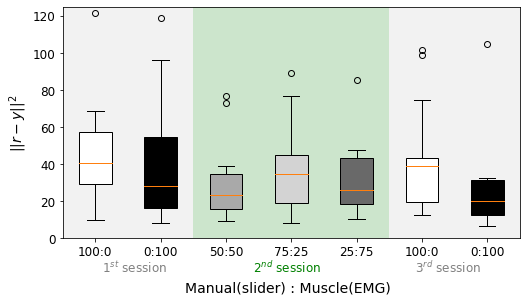

In [48]:
MSEtvalues,MSEtvalues5 = MSETIME(last_trial)

fig,axs = BOXPLOT(MSEtvalues,'$||r-y||^2$',ylimit0 = (0,125))
# fig.suptitle(plot_title)
plt.axvspan(0.5,2.5, facecolor='grey', alpha=0.1)
plt.axvspan(2.5,5.5, facecolor='green', alpha=0.2)
plt.axvspan(5.5,7.5, facecolor='grey', alpha=0.1)
plt.text(0.2,0.14, r'$1^{st}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.text(0.48,0.14, r'$2^{nd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'green')
plt.text(0.78,0.14, r'$3^{rd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.tight_layout()
plt.show()

# fig,axs = BOXPLOT5(MSEtvalues5,'$\sum |r-y|^2$',ylimit0=100)

# plt.tight_layout()
# plt.show()

In [713]:
w,pv,sig,flag = WilcoxonTest(MSEtvalues)
flag

['there is significant difference between condition 0 and condition 1, w = 20.0, pvalue = 0.02154541015625',
 'there is significant difference between condition 0 and condition 2, w = 4.0, pvalue = 0.00042724609375',
 'there is significant difference between condition 0 and condition 3, w = 17.0, pvalue = 0.012451171875',
 'there is significant difference between condition 0 and condition 4, w = 24.0, pvalue = 0.041259765625',
 'there is significant difference between condition 0 and condition 5, w = 16.0, pvalue = 0.01025390625',
 'there is significant difference between condition 0 and condition 6, w = 17.0, pvalue = 0.012451171875',
 'there is significant difference between condition 1 and condition 2, w = 23.0, pvalue = 0.03533935546875',
 'there is significant difference between condition 1 and condition 6, w = 24.0, pvalue = 0.041259765625',
 'there is significant difference between condition 2 and condition 3, w = 25.0, pvalue = 0.04791259765625',
 'there is significant differen

In [705]:
w,p,sig,flag = TTest(MSEtvalues)
flag

['there is significant difference between condition 1 and condition 2, w = 2.1890510989692706, pvalue = 0.04603480407011774']

In [441]:
# w,pv,sig,flag = WilcoxonTest(MSEtvalues5)
# flag

['there is significant difference between condition 0 and condition 2, w = 4.0, pvalue = 0.00042724609375',
 'there is significant difference between condition 0 and condition 3, w = 23.0, pvalue = 0.03533935546875',
 'there is significant difference between condition 1 and condition 2, w = 25.0, pvalue = 0.04791259765625',
 'there is significant difference between condition 2 and condition 3, w = 21.0, pvalue = 0.02557373046875',
 'there is significant difference between condition 2 and condition 4, w = 18.0, pvalue = 0.01507568359375']

In [442]:
# w,p,sig,flag = TTest(MSEtvalues5)
# flag

[]

## freq domain tracking errror

In [49]:
def MSEFREQ(last_trial,first_freq):
    """
    number of trials to look at of each condition: (ex: last 4)
    last_trial = [4,4,8,8,8,4,4]

    what freqs to look at over all 8 stim freqs: (ex: [1,2,3,4,5,6,7,8])
    first_freq = [0,1,2,3,4,5,6,7]
    """
    #(2) MSE freq: for every two trial for every participant (1 number for evry two trial)
    MSEf = {}
    for p in range(participants_num): # number of participants = 15
        MSEf['subject'+str(p)] = {}
        for c in range(num_cond):  # number of conditions  = 7
            #freq domain error of every two trials of each participantof every condition
            R_Y = (np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R']) - 
                    np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['Y']))
            MSEf['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(R_Y[-last_trial[c]:][:,stimulated_index[first_freq]]))**2 ,axis=1) 
            #normalize by freq^2
    
    MSEfvalues = [] # 7 conditions x (15participants * i/2 trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(MSEf['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        MSEfvalues.append(values_)

    MSEfvalues5 = [] # 5 conditions x (15participants * i/2 trials)
    for c in range(num_cond-2):
        values_ = []
        for p in range(participants_num):
            if c==0:
                values_.append(np.mean(np.concatenate([MSEf['subject'+str(p)]['condition'+str(c)],MSEf['subject'+str(p)]['condition'+str(5)]])) )
            elif c==1:
                values_.append(np.mean(np.concatenate([MSEf['subject'+str(p)]['condition'+str(c)],MSEf['subject'+str(p)]['condition'+str(6)]])) )
            else:
                values_.append(np.mean(MSEf['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        MSEfvalues5.append(values_)

    return MSEfvalues,MSEfvalues5 #average MSE over all trials for every participant

In [50]:
# last_trial = [5,5,5,5,5,4,4]
last_trial = [5,5,5,5,5,2,2]
last_trial = [4,4,4,4,4,4,4]

# what freqs to look at over all 8 stim freqs: (ex: [0,1,2,3,4,5,6,7])
first_freq = [0,1,2,3,4,5,6,7]
# first_freq = [0,1]

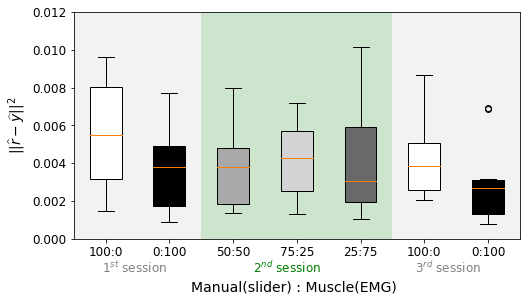

In [51]:
MSEfvalues,MSEfvalues5= MSEFREQ(last_trial,first_freq)

fig,axs = BOXPLOT(MSEfvalues,'$||\widehat{r}-\widehat{y}||^2$',ylimit0 = (0,0.012))
# fig.suptitle(plot_title)
plt.axvspan(0.5,2.5, facecolor='grey', alpha=0.1)
plt.axvspan(2.5,5.5, facecolor='green', alpha=0.2)
plt.axvspan(5.5,7.5, facecolor='grey', alpha=0.1)
plt.text(0.2,0.14, r'$1^{st}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.text(0.48,0.14, r'$2^{nd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'green')
plt.text(0.78,0.14, r'$3^{rd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.tight_layout()
plt.show()

# fig,axs = BOXPLOT5(MSEfvalues5,'$\sum |R-Y|^2$',ylimit0=0.008)
# plt.tight_layout()
# plt.show()

In [58]:
w,pv,sig,flag = WilcoxonTest(MSEfvalues)
flag

['there is significant difference between condition 0 and condition 1, w = 3.0, pvalue = 0.00030517578125',
 'there is significant difference between condition 0 and condition 2, w = 3.0, pvalue = 0.00030517578125',
 'there is significant difference between condition 0 and condition 4, w = 24.0, pvalue = 0.041259765625',
 'there is significant difference between condition 0 and condition 5, w = 15.0, pvalue = 0.00836181640625',
 'there is significant difference between condition 0 and condition 6, w = 15.0, pvalue = 0.00836181640625',
 'there is significant difference between condition 1 and condition 6, w = 23.0, pvalue = 0.03533935546875']

In [59]:
w,pv,sig,flag = TTest(MSEfvalues)
flag

['there is significant difference between condition 0 and condition 1, w = 2.6802261287574587, pvalue = 0.017937597411469802',
 'there is significant difference between condition 0 and condition 2, w = 2.1716188704414603, pvalue = 0.04756004677502716']

## R-Y below crossover

In [688]:
def RY_Cross(last_trial):
    """
    number of trials to look at of each condition: (ex: last 4)
    last_trial = [4,4,8,8,8,4,4]

    what freqs to look at over all 8 stim freqs: (ex: [1,2,3,4,5,6,7,8])
    first_freq = [0,1,2,3,4,5,6,7]
    """
    #(2) MSE freq: for every two trial for every participant (1 number for evry two trial)
    crossover_index = [0,1,2,3,4,5,6,7,8,9]
    crossover_freq = xf[:10]
    MSEf = {}
    for p in range(participants_num): # number of participants = 15
        MSEf['subject'+str(p)] = {}
        for c in range(num_cond):  # number of conditions  = 7
            #freq domain error of every two trials of each participantof every condition
            R_Y = (np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R']) - 
                    np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['Y']))
            MSEf['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(R_Y[-last_trial[c]:][:,crossover_index]))**2 ,axis=1) 
    
    MSEfvalues = [] # 7 conditions x (15participants * i/2 trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(MSEf['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        MSEfvalues.append(values_)

    return MSEfvalues #average MSE over all trials for every participant

In [689]:


# last_trial = [5,5,5,5,5,4,4]
last_trial = [5,5,5,5,5,2,2]
last_trial = [4,4,4,4,4,4,4]

# what freqs to look at over all 8 stim freqs: (ex: [0,1,2,3,4,5,6,7])
# first_freq = [0,1,2,3,4,5,6,7]
first_freq = [0,1]

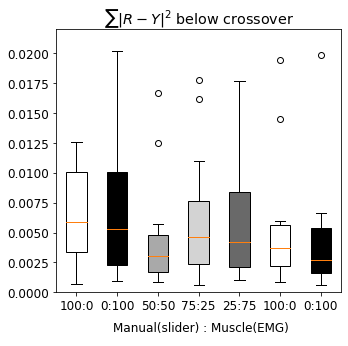

In [694]:
RY_Crossvalues= RY_Cross(last_trial)

fig,axs = BOXPLOT(RY_Crossvalues,'$\sum |R-Y|^2$ below crossover stim&non-stim',ylimit0 = 0.022) 
# fig.suptitle(plot_title)
plt.tight_layout()
plt.show()

In [695]:
w,pv,sig,flag = WilcoxonTest(RY_Crossvalues)
flag

['there is significant difference between condition 0 and condition 2, w = 20.0, pvalue = 0.02154541015625',
 'there is significant difference between condition 0 and condition 5, w = 11.0, pvalue = 0.00335693359375',
 'there is significant difference between condition 1 and condition 2, w = 17.0, pvalue = 0.012451171875',
 'there is significant difference between condition 1 and condition 6, w = 22.0, pvalue = 0.0301513671875',
 'there is significant difference between condition 2 and condition 4, w = 14.0, pvalue = 0.0067138671875']

## R-Y at non-stim freqs

In [109]:
#mask for index of freq that are less than 1Hz
def lessthanone(x): return x <= 1.0
indexone = [idx for idx, element in enumerate(xf) if lessthanone(element)]
unwanted_index = {4, 6, 10, 14, 22, 26, 34, 38}
nonstimulated_index = [i for i in indexone if i not in unwanted_index] #nonstim index below 1Hz
all_nonstimulated_index = [i for i in range(N//2) if i not in unwanted_index] # all nonstim index 

In [114]:
def RY_NONSTIM(last_trial):
    """
    number of trials to look at of each condition: (ex: last 4)
    last_trial = [4,4,8,8,8,4,4]

    what freqs to look at over all 8 stim freqs: (ex: [1,2,3,4,5,6,7,8])
    first_freq = [0,1,2,3,4,5,6,7]
    """
    #(2) MSE freq: for every two trial for every participant (1 number for evry two trial)
    MSEf = {}
    for p in range(participants_num): # number of participants = 15
        MSEf['subject'+str(p)] = {}
        for c in range(num_cond):  # number of conditions  = 7
            #freq domain error of every two trials of each participantof every condition
            R_Y = (np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R']) - 
                    np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['Y']))
            MSEf['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(R_Y[-last_trial[c]:][:,all_nonstimulated_index]))**2 ,axis=1) 
    
    MSEfvalues = [] # 7 conditions x (15participants * i/2 trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(MSEf['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        MSEfvalues.append(values_)

    return MSEfvalues#average MSE over all trials for every participant

In [115]:
last_trial = [4,4,4,4,4,4,4]

# what freqs to look at over all 8 stim freqs: (ex: [0,1,2,3,4,5,6,7])
# first_freq = [0,1,2,3,4,5,6,7]
first_freq = [0,1]

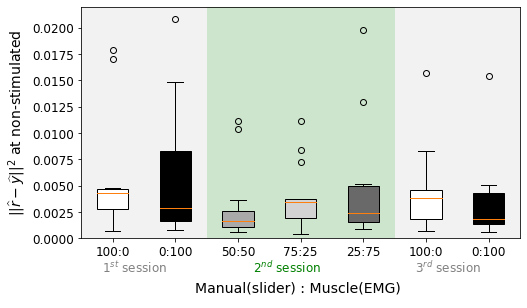

In [116]:
RY_NONSTIMvalues= RY_NONSTIM(last_trial)

fig,axs = BOXPLOT(RY_NONSTIMvalues,r'$||\widehat{r}-\widehat{y}||^2$ at non-stimulated',ylimit0 = (0,0.022)) 
# fig.suptitle(plot_title)
plt.axvspan(0.5,2.5, facecolor='grey', alpha=0.1)
plt.axvspan(2.5,5.5, facecolor='green', alpha=0.2)
plt.axvspan(5.5,7.5, facecolor='grey', alpha=0.1)
plt.text(0.2,0.14, r'$1^{st}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.text(0.48,0.14, r'$2^{nd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'green')
plt.text(0.78,0.14, r'$3^{rd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.tight_layout()
plt.show()

In [117]:
w,pv,sig,flag = WilcoxonTest(RY_NONSTIMvalues)
flag

['there is significant difference between condition 0 and condition 2, w = 15.0, pvalue = 0.00836181640625',
 'there is significant difference between condition 0 and condition 3, w = 14.0, pvalue = 0.0067138671875',
 'there is significant difference between condition 1 and condition 2, w = 3.0, pvalue = 0.00030517578125',
 'there is significant difference between condition 2 and condition 4, w = 15.0, pvalue = 0.00836181640625',
 'there is significant difference between condition 2 and condition 5, w = 11.0, pvalue = 0.00335693359375',
 'there is significant difference between condition 2 and condition 6, w = 20.0, pvalue = 0.02154541015625',
 'there is significant difference between condition 3 and condition 5, w = 17.0, pvalue = 0.012451171875']

## R-Y at all freq (stim + non stim)

In [48]:
def RY_ALLFREQ(last_trial):
    MSEf = {}
    for p in range(participants_num): # number of participants = 15
        MSEf['subject'+str(p)] = {}
        for c in range(num_cond):  # number of conditions  = 7
            #freq domain error of every two trials of each participantof every condition
            R_Y = (np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R']) - 
                    np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['Y']))
            MSEf['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(R_Y[-last_trial[c]:][:,:N//2]))**2 ,axis=1) 
    
    MSEfvalues = [] # 7 conditions x (15participants * i/2 trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(MSEf['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        MSEfvalues.append(values_)

    return MSEfvalues#average MSE over all trials for every participant

In [49]:
last_trial = [4,4,4,4,4,4,4]

# what freqs to look at over all 8 stim freqs: (ex: [0,1,2,3,4,5,6,7])
# first_freq = [0,1,2,3,4,5,6,7]
first_freq = [0,1]

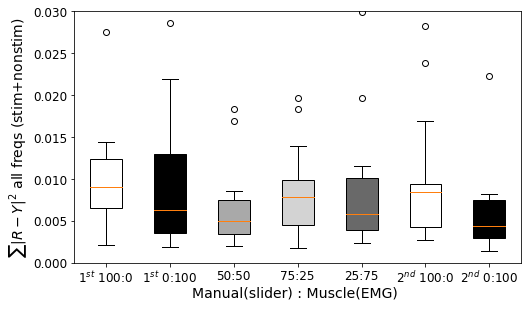

In [50]:
RY_ALLFREQvalues= RY_ALLFREQ(last_trial)

fig,axs = BOXPLOT(RY_ALLFREQvalues,'$\sum |R-Y|^2$ all freqs (stim+nonstim)',ylimit0 = (0,0.03)) 
# fig.suptitle(plot_title)
plt.tight_layout()
plt.show()

In [51]:
w,pv,sig,flag = WilcoxonTest(RY_ALLFREQvalues)
flag

['there is significant difference between condition 0 and condition 2, w = 11.0, pvalue = 0.00335693359375',
 'there is significant difference between condition 0 and condition 3, w = 19.0, pvalue = 0.01806640625',
 'there is significant difference between condition 0 and condition 5, w = 22.0, pvalue = 0.0301513671875',
 'there is significant difference between condition 0 and condition 6, w = 18.0, pvalue = 0.01507568359375',
 'there is significant difference between condition 1 and condition 2, w = 23.0, pvalue = 0.03533935546875',
 'there is significant difference between condition 1 and condition 6, w = 23.0, pvalue = 0.03533935546875',
 'there is significant difference between condition 2 and condition 4, w = 20.0, pvalue = 0.02154541015625',
 'there is significant difference between condition 2 and condition 5, w = 17.0, pvalue = 0.012451171875']

## freq domain inversion error

In [59]:
def InversionError(last_trial,first_freq):
    """
    number of trials to look at of each condition: (ex: last 4)
    last_trial = [4,4,8,8,8,4,4]

    what freqs to look at over all 8 stim freqs: (ex: [1,2,3,4,5,6,7,8])
    first_freq = [0,1,2,3,4,5,6,7]
    """
    #(2) MSE freq: for every two trial for every participant (1 number for evry two trial)
    MSEf = {}
    for p in range(participants_num): # number of participants = 15
        MSEf['subject'+str(p)] = {}
        for c in range(num_cond):  # number of conditions  = 7
            #freq domain error of every two trials of each participantof every condition
            error = np.abs(TF['F']['subject'+str(p)]['condition'+str(c)][-(last_trial[c]//2):] - 1/M_h[stimulated_index])
            MSEf['subject'+str(p)]['condition'+str(c)] = np.sum( (error**2)[:,first_freq] ,axis=1) 
    
    MSEfvalues = [] # 7 conditions x (15participants * i/2 trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(MSEf['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        MSEfvalues.append(values_)

    MSEfvalues5 = [] # 5 conditions x (15participants * i/2 trials)
    for c in range(num_cond-2):
        values_ = []
        for p in range(participants_num):
            if c==0:
                values_.append(np.mean(np.concatenate([MSEf['subject'+str(p)]['condition'+str(c)],MSEf['subject'+str(p)]['condition'+str(5)]])) )
            elif c==1:
                values_.append(np.mean(np.concatenate([MSEf['subject'+str(p)]['condition'+str(c)],MSEf['subject'+str(p)]['condition'+str(6)]])) )
            else:
                values_.append(np.mean(MSEf['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        MSEfvalues5.append(values_)

    return MSEfvalues,MSEfvalues5 #average MSE over all trials for every participant

In [60]:
last_trial = [4,4,4,4,4,4,4]

# first_freq = [0,1,2,3,4,5,6,7]
first_freq = [0,1]

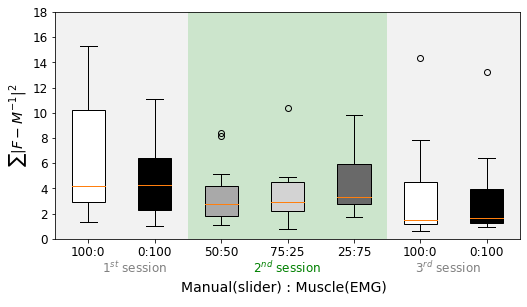

In [62]:
FWvalues,FWvalues5= InversionError(last_trial,first_freq)

fig,axs = BOXPLOT(FWvalues,'$\sum |F-M^{-1}|^2$',ylimit0 = (0,18))
plt.axvspan(0.5,2.5, facecolor='grey', alpha=0.1)
plt.axvspan(2.5,5.5, facecolor='green', alpha=0.2)
plt.axvspan(5.5,7.5, facecolor='grey', alpha=0.1)
plt.text(0.2,0.14, r'$1^{st}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.text(0.48,0.14, r'$2^{nd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'green')
plt.text(0.78,0.14, r'$3^{rd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.tight_layout()
plt.show()

In [63]:
w,pv,sig,flag = WilcoxonTest(FWvalues)
flag

['there is significant difference between condition 0 and condition 2, w = 25.0, pvalue = 0.04791259765625',
 'there is significant difference between condition 0 and condition 5, w = 23.0, pvalue = 0.03533935546875']

## B

In [20]:
def B_NORM_sqaure(last_trial,first_freq):
    """
    number of trials to look at of each condition: (ex: last 4)
    last_trial = [4,4,8,8,8,4,4]

    what freqs to look at over all 8 stim freqs: (ex: [1,2,3,4,5,6,7,8])
    first_freq = [0,1,2,3,4,5,6,7]

    TFtype = 'F', 'F0', 'F1', 'TYR','TYD'...
    """

    # TFnorm: for every two trial for every participant (1 number for evry two trial)
    TFnorm = {}
    for p in range(participants_num): 
        TFnorm['subject'+str(p)] = {}
        for c in range(num_cond): 
            TFnorm['subject'+str(p)]['condition'+str(c)] = (LA.norm(TF['B']['subject'+str(p)]['condition'+str(c)][-(last_trial[c]//2):][:,first_freq],axis = 1))**2
    
    TFvalues = [] # 7 conditions x (15participants * i/2 trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(TFnorm['subject'+str(p)]['condition'+str(c)])) #average of all trials of a participant of a condition
        TFvalues.append(values_)

    return TFvalues #average MSE over all trials for every participant

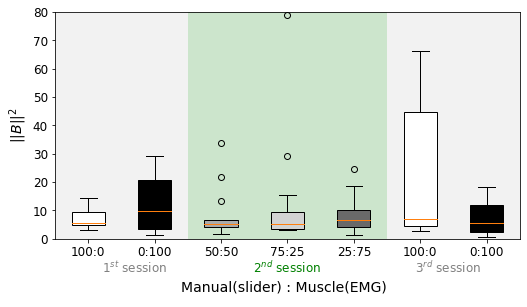

In [31]:
last_trial = [4,4,4,4,4,4,4]
# last_trial = [2,2,2,2,2,2,2]
# first_freq = [0,1,2,3,4,5,6,7]
first_freq = [0,1]
Bvalues = B_NORM_sqaure(last_trial,first_freq)

fig,axs = BOXPLOT(Bvalues,r'$||B||^2$',ylimit0 = (0,80))
plt.axvspan(0.5,2.5, facecolor='grey', alpha=0.1)
plt.axvspan(2.5,5.5, facecolor='green', alpha=0.2)
plt.axvspan(5.5,7.5, facecolor='grey', alpha=0.1)
plt.text(0.2,0.14, r'$1^{st}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.text(0.48,0.14, r'$2^{nd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'green')
plt.text(0.78,0.14, r'$3^{rd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.tight_layout()
plt.show()

In [32]:
w,pv,sig,flag = WilcoxonTest(Bvalues)
flag

['there is significant difference between condition 2 and condition 5, w = 24.0, pvalue = 0.041259765625']

# Hypothesis 1b - reference tracking errors decreases

## freq domain R-Y at reference freq

In [315]:
def MSE_REF(last_trial,first_freq):
    """
    number of trials to look at of each condition: (ex: last 4)
    last_trial = [4,4,8,8,8,4,4]

    what freqs to look at over all 8 stim freqs: (ex: [1,2,3,4,5,6,7,8])
    first_freq = [0,1,2,3,4,5,6,7]
    """
    #EO trials: dis,ref,... #trial 0, 2, ..., 12
    #OE trials: ref,dis,... #trial 1, 3, ..., 13 (last trial)
    MSEf = {}
    even_index = [0,2,4,6]
    odd_index = [1,3,5,7]

    for p in range(participants_num): # number of participants = 15
        MSEf['subject'+str(p)] = {}
        for c in range(num_cond):  # number of conditions  = 7
            #freq domain error of every two trials of each participantof every condition
            R_Y = (np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R']) - 
                    np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['Y']))
            Y_stim_EO = R_Y[-last_trial[c]::2][:,stimulated_index[odd_index]]#[:,stimulated_index[first_freq]]
            Y_stim_OE = R_Y[-last_trial[c]+1::2][:,stimulated_index[even_index]]#[:,stimulated_index[first_freq]]
            ref_stim_all = np.concatenate([Y_stim_EO,Y_stim_OE]) #order doesn't matter since we are taking the 2-norm
            # ref_error_EO = np.sum( (np.abs(Y_stim_EO[:,1::2]))**2 ,axis=1) #LA.norm(Y_stim_OE[:,1::2],axis = 1) 
            # ref_error_OE = np.sum( (np.abs(Y_stim_OE[:,::2]))**2 ,axis=1) #LA.norm(Y_stim_EO[:,::2],axis = 1)
            
            MSEf['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(ref_stim_all))**2 ,axis=1) #np.concatenate([ref_error_OE,ref_error_EO])

    MSEfvalues = [] # 7 conditions x (15participants * i/2 trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(MSEf['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        MSEfvalues.append(values_)

    return MSEfvalues #average MSE over all trials for every participant

In [316]:
# last_trial = [5,5,5,5,5,2,2]
# last_trial = [5,5,5,5,5,4,4]
last_trial = [4,4,4,4,4,4,4]


first_freq = [0,1,2,3,4,5,6,7]
# first_freq = [0,1]

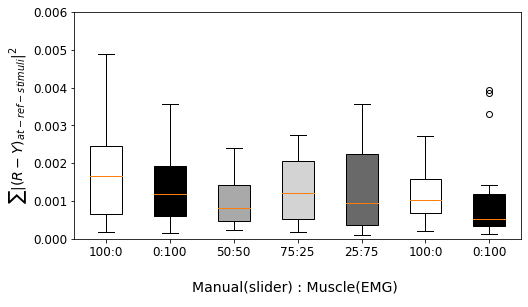

In [318]:
REFvalues= MSE_REF(last_trial,first_freq)

fig,axs = BOXPLOT(REFvalues,'$\sum |(R-Y)_{at-ref-stimuli}|^2$',ylimit0 = (0,0.006))
# fig.suptitle(plot_title)
plt.tight_layout()
plt.show()

In [319]:
w,pv,sig,flag = WilcoxonTest(REFvalues)
flag

['there is significant difference between condition 0 and condition 1, w = 20.0, pvalue = 0.02154541015625',
 'there is significant difference between condition 0 and condition 2, w = 10.0, pvalue = 0.00262451171875',
 'there is significant difference between condition 0 and condition 3, w = 17.0, pvalue = 0.012451171875',
 'there is significant difference between condition 0 and condition 5, w = 23.0, pvalue = 0.03533935546875',
 'there is significant difference between condition 0 and condition 6, w = 13.0, pvalue = 0.00537109375']

In [607]:
w,pv,sig,flag = TTest(REFvalues)
flag

[]

## |Tyr-1| 2-norm

In [1017]:
# def TF_NORM(last_trial,first_freq,TFtype):
#     """
#     number of trials to look at of each condition: (ex: last 4)
#     last_trial = [4,4,8,8,8,4,4]

#     what freqs to look at over all 8 stim freqs: (ex: [1,2,3,4,5,6,7,8])
#     first_freq = [0,1,2,3,4,5,6,7]

#     TFtype = 'F', 'F0', 'F1', 'TYR','TYD'...
#     """

#     # TFnorm: for every two trial for every participant (1 number for evry two trial)
#     TFnorm = {}
#     for p in range(participants_num): 
#         TFnorm['subject'+str(p)] = {}
#         for c in range(num_cond): 
#             if TFtype == 'TYR': # then calculate TYR-1
#                 # np.sum((np.abs(TF[TFtype]['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq])-1)**2,axis = 1)
#                 TFnorm['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(TF[TFtype]['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq]-1))**2,axis = 1 )
            
#             elif TFtype == 'TUD': # then calculate TUD-(-1)
#                 TFnorm['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(TF[TFtype]['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq]+1))**2,axis = 1 )
            
#             else:
#             #F of every two trials of each participant of every condition
#                 TFnorm['subject'+str(p)]['condition'+str(c)] = np.sum((np.abs(TF[TFtype]['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq]))**2,axis = 1)
    
#     TFvalues = [] # 7 conditions x (15participants * i/2 trials)
#     for c in range(num_cond):
#         values_ = []
#         for p in range(participants_num):
#             values_.append(np.mean(TFnorm['subject'+str(p)]['condition'+str(c)])) #average of all trials of a participant of a condition
#         TFvalues.append(values_)

#     # TFvalues5 = [] # 5 conditions x (15participants * i/2 trials)
#     # for c in range(num_cond-2):
#     #     values_ = []
#     #     for p in range(participants_num):
#     #         if c==0:
#     #             values_.append(np.mean(np.concatenate([TFnorm['subject'+str(p)]['condition'+str(c)],TFnorm['subject'+str(p)]['condition'+str(5)]]))) 
#     #             #average of all trials of a participant of a condition
#     #         elif c==1:
#     #             values_.append(np.mean(np.concatenate([TFnorm['subject'+str(p)]['condition'+str(c)],TFnorm['subject'+str(p)]['condition'+str(6)]]))) 
#     #         else:
#     #             values_.append(np.mean(TFnorm['subject'+str(p)]['condition'+str(c)])) #average of all trials of a participant of a condition
#     #     TFvalues5.append(values_)

#     return TFvalues#,TFvalues5 #average MSE over all trials for every participant

In [60]:
# def TF_NORM(last_trial,first_freq,TFtype):
#     """
#     number of trials to look at of each condition: (ex: last 4)
#     last_trial = [4,4,8,8,8,4,4]

#     what freqs to look at over all 8 stim freqs: (ex: [1,2,3,4,5,6,7,8])
#     first_freq = [0,1,2,3,4,5,6,7]

#     TFtype = 'F', 'F0', 'F1', 'TYR','TYD'...
#     """

#     # TFnorm: for every two trial for every participant (1 number for evry two trial)
#     TFnorm = {}
#     for p in range(participants_num): 
#         TFnorm['subject'+str(p)] = {}
#         for c in range(num_cond): 
#             if TFtype == 'TYR': # then calculate TYR-1, normalize by freq^2
#                 # np.sum((np.abs(TF[TFtype]['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq])-1)**2,axis = 1)
#                 TFnorm['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(TF[TFtype]['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq]-1) / (stimulated_freq**2))**2,axis = 1 )
#             else: # elif TFtype == 'TUD': # then calculate TUD-(-1)
#                 TFnorm['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(TF[TFtype]['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq]+1) )**2,axis = 1 )
            
#     TFvalues = [] # 7 conditions x (15participants * i/2 trials)
#     for c in range(num_cond):
#         values_ = []
#         for p in range(participants_num):
#             values_.append(1e-4*np.mean(TFnorm['subject'+str(p)]['condition'+str(c)])) #average of all trials of a participant of a condition
#         TFvalues.append(values_)

#     return TFvalues #average MSE over all trials for every participant

In [126]:
# p=0
# c=0
# i=0
# R = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R'][i][:N//2] )
# MD = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['MD'][i][:N//2] )
# WR = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['WR'][i][:N//2] )
# D = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['D'][i][:N//2] )
# output_stimuli_mag = np.zeros(8)
# output_stimuli_mag[1::2] = R[R>1e-4]
# output_stimuli_mag[::2] = MD[MD>1e-4]
# input_stimuli_mag = np.zeros(8)
# input_stimuli_mag[1::2] = WR[R>1e-4]
# input_stimuli_mag[::2] = D[MD>1e-4]
# # input_stimuli_mag

In [64]:
p=0
c=0
i=0
#EO trials: dis,ref,... #trial 0, 2, ..., 12
R = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R'][i][:N//2]  
MD =  DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['MD'][i][:N//2] 
WR =  DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['WR'][i][:N//2] 
D =  DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['D'][i][:N//2] 
output_stimuli = np.zeros(8,dtype = complex)
output_stimuli[1::2] = R[np.abs(R)>1e-4]
output_stimuli[::2] = MD[np.abs(MD)>1e-4]
input_stimuli = np.zeros(8,dtype = complex)
input_stimuli[1::2] = WR[np.abs(R)>1e-4]
input_stimuli[::2] = D[np.abs(MD)>1e-4]
output_stimuli

array([ 2.94470953e-02+0.041338j  , -9.31533455e-05-0.03383583j,
       -9.92477396e-03+0.01771024j, -1.15928662e-02+0.00871137j,
       -7.74601514e-03-0.00501548j, -6.89569389e-03-0.00366318j,
        5.84340299e-03-0.00122804j, -7.94047354e-04-0.00528318j])

In [65]:
p=0
c=0
i=1
#OE trials: ref,dis,... #trial 1, 3, ..., 13 (last trial)
R = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R'][i][:N//2] 
MD =  DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['MD'][i][:N//2] 
WR =  DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['WR'][i][:N//2] 
D =  DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['D'][i][:N//2] 
output_stimuli = np.zeros(8,dtype = complex)
output_stimuli[::2] = R[np.abs(R)>1e-4]
output_stimuli[1::2] = MD[np.abs(MD)>1e-4]
input_stimuli = np.zeros(8,dtype = complex)
input_stimuli[::2] = WR[np.abs(R)>1e-4]
input_stimuli[1::2] = D[np.abs(MD)>1e-4]
output_stimuli

array([-0.04800399-0.01647964j, -0.01580675+0.02991686j,
        0.01839657-0.00858603j,  0.00282516-0.01422326j,
        0.00326493+0.00863111j,  0.00779775-0.00040577j,
       -0.00553596-0.00223754j,  0.00181738+0.00502391j])

In [66]:
scaleOut = 0.8120629258740933
vfs = ['so']
period = 20 # sec
f_base = 1./period # Hz
# TODO go up to 3--5Hz -- check that Sam can track, and check when becomes sub-pixel
primes = np.asarray([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199])
f_max = dict(fo=2,so=1)
p_max = dict([(vf,np.nonzero(primes*f_base <= f_max[vf])[0][-1]+1) for vf in vfs])
f_primes = dict([(vf,np.asarray(primes[:p_max[vf]])) for vf in vfs])
frequencies = dict([(vf,f_primes[vf]*f_base) for vf in vfs])
frequencies_r = frequencies.copy()
frequencies_d = frequencies.copy()
amplitudes = dict([(vf,scaleOut*(1./f_primes[vf])) for vf in vfs])
# amplitudes = dict([(vf,(1./f_primes[vf])*(0.5/f_primes[vf]).sum()) for vf in vfs])
amplitudes_r = amplitudes.copy()
# amplitudes_d = amplitudes.copy()
#d = Md/M
amplitudes_output = amplitudes_r['so']
amplitudes_input = amplitudes_r['so'] / abs(M_h[stimulated_index])

In [67]:
def TYR_NORM(last_trial,first_freq,TFtype):

    # TFnorm: for every two trial for every participant (1 number for evry two trial)
    TFnorm = {}
    for p in range(participants_num): 
        TFnorm['subject'+str(p)] = {}
        for c in range(num_cond):  # then calculate TYR-1, normalize by freq^2
            # TFnorm['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(TF['TYR']['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq]-1) / (stimulated_freq))**2,axis = 1 )
            # TFnorm['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(TF['TYR']['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq]-1) * amplitudes_output)**2,axis = 1 )
            TFnorm['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(TF['TYR']['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq]-1) * amplitudes_output)**2,axis = 1 )

        
    TFvalues = [] # 7 conditions x (15participants * i/2 trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(TFnorm['subject'+str(p)]['condition'+str(c)])) #average of all trials of a participant of a condition
        TFvalues.append(values_)

    return TFvalues #average MSE over all trials for every participant

In [68]:
last_trial = [5,5,5,5,5,2,2]
# last_trial = [5,5,5,5,5,4,4]
last_trial = [4,4,4,4,4,4,4]


first_freq = [0,1,2,3,4,5,6,7]
# first_freq = [0,1]

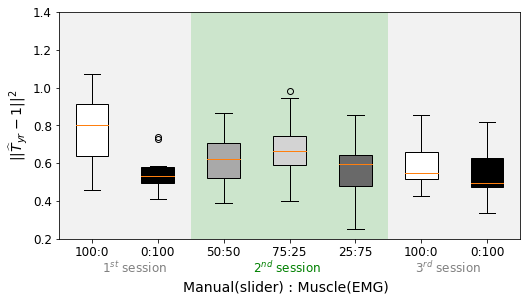

In [71]:
TYRvalues = TYR_NORM(last_trial,first_freq,'TYR')

fig,axs = BOXPLOT(TYRvalues,'$||\widehat{T}_{yr}-1||^2$',ylimit0 = (0.2,1.4)) #,ylimit0 = (0.5,11)
# fig.suptitle(plot_title)
plt.axvspan(0.5,2.5, facecolor='grey', alpha=0.1)
plt.axvspan(2.5,5.5, facecolor='green', alpha=0.2)
plt.axvspan(5.5,7.5, facecolor='grey', alpha=0.1)
plt.text(0.2,0.14, r'$1^{st}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.text(0.48,0.14, r'$2^{nd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'green')
plt.text(0.78,0.14, r'$3^{rd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.tight_layout()
plt.show()

# fig,axs = BOXPLOT5(TYRvalues5,'$|\widehat{T_{yr}}-1|_{2}$')
# # fig.suptitle(plot_title)
# plt.tight_layout()
# plt.show()

In [70]:
w,pv,sig,flag = WilcoxonTest(TYRvalues)
flag

['there is significant difference between condition 0 and condition 1, w = 14.0, pvalue = 0.0067138671875',
 'there is significant difference between condition 0 and condition 5, w = 11.0, pvalue = 0.00335693359375',
 'there is significant difference between condition 0 and condition 6, w = 4.0, pvalue = 0.00042724609375',
 'there is significant difference between condition 3 and condition 6, w = 22.0, pvalue = 0.0301513671875']

In [72]:
w,pv,sig,flag = TTest(TYRvalues)
flag

['there is significant difference between condition 0 and condition 6, w = 2.4829436157855875, pvalue = 0.02631921820222461',
 'there is significant difference between condition 3 and condition 6, w = 2.7448734346361974, pvalue = 0.01580324157499709']

# Hypothesis 1c - disturbance rejection improves

## freq domain Y at disturbance freq

In [73]:
def MSE_DIS(last_trial,first_freq):
    """
    number of trials to look at of each condition: (ex: last 4)
    last_trial = [4,4,8,8,8,4,4]

    what freqs to look at over all 8 stim freqs: (ex: [1,2,3,4,5,6,7,8])
    first_freq = [0,1,2,3,4,5,6,7]
    """
    #EO trials: dis,ref,... #trial 0, 2, ..., 12
    #OE trials: ref,dis,... #trial 1, 3, ..., 13 (last trial)
    MSEf = {}
    even_index = [0,2,4,6]
    odd_index = [1,3,5,7]

    for p in range(participants_num): # number of participants = 15
        MSEf['subject'+str(p)] = {}
        for c in range(num_cond):  # number of conditions  = 7
            #freq domain error of every two trials of each participantof every condition
            R_Y = (np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R']) - 
                    np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['Y']))
            # R_Y = (np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R']))
            Y_stim_EO = R_Y[-last_trial[c]::2][:,stimulated_index[even_index]]#R_Y[-last_trial[c]::2][:,stimulated_index[first_freq]]
            Y_stim_OE = R_Y[-last_trial[c]::2][:,stimulated_index[odd_index]]#R_Y[-last_trial[c]+1::2][:,stimulated_index[first_freq]]
            dis_stim_all = np.concatenate([Y_stim_EO,Y_stim_OE])
            # Y_stim_OE = np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['Y'][-last_trial[c]::2])[:,stimulated_index[first_freq]]
            # Y_stim_EO = np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['Y'][-last_trial[c]+1::2])[:,stimulated_index[first_freq]]
            # dis_error_EO = np.sum(np.abs((Y_stim_EO[:,::2])**2),axis=1) #LA.norm(Y_stim_OE[:,1::2],axis = 1) 
            # dis_error_OE = np.sum(np.abs((Y_stim_OE[:,1::2])**2),axis=1) #LA.norm(Y_stim_EO[:,::2],axis = 1)
            
            MSEf['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(dis_stim_all))**2 ,axis=1)#np.concatenate([dis_error_OE,dis_error_EO])

    MSEfvalues = [] # 7 conditions x (15participants * i/2 trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(MSEf['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        MSEfvalues.append(values_)

    return MSEfvalues #average MSE over all trials for every participant

In [74]:
# last_trial = [5,5,5,5,5,2,2]
# last_trial = [5,5,5,5,5,4,4]
last_trial = [4,4,4,4,4,4,4]


first_freq = [0,1,2,3,4,5,6,7]
# first_freq = [0,1]

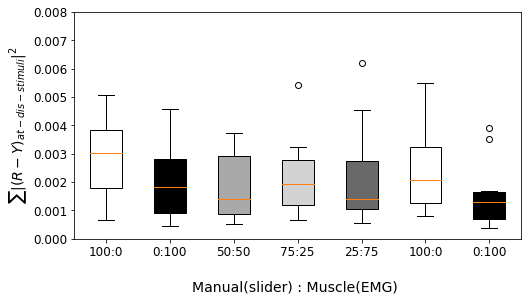

In [75]:
DISvalues= MSE_DIS(last_trial,first_freq)

fig,axs = BOXPLOT(DISvalues,'$\sum |(R-Y)_{at-dis-stimuli}|^2$',ylimit0 = (0,0.008))
# fig.suptitle(plot_title)
plt.tight_layout()
plt.show()

# fig,axs = BOXPLOT5(DISvalues5,'$\sum |Y_{at-dis-stimuli}|^2$',ylimit0=0.008)
# plt.tight_layout()
# plt.show()

In [314]:
w,pv,sig,flag = WilcoxonTest(DISvalues)
flag

['there is significant difference between condition 0 and condition 1, w = 10.0, pvalue = 0.00262451171875',
 'there is significant difference between condition 0 and condition 2, w = 5.0, pvalue = 0.0006103515625',
 'there is significant difference between condition 0 and condition 3, w = 16.0, pvalue = 0.01025390625',
 'there is significant difference between condition 0 and condition 4, w = 13.0, pvalue = 0.00537109375',
 'there is significant difference between condition 0 and condition 6, w = 16.0, pvalue = 0.01025390625',
 'there is significant difference between condition 5 and condition 6, w = 25.0, pvalue = 0.04791259765625']

In [586]:
w,pv,sig,flag = TTest(TYRvalues)
flag

['there is significant difference between condition 0 and condition 1, w = 2.774383041534763, pvalue = 0.014913174516316035',
 'there is significant difference between condition 0 and condition 2, w = 2.6524042168014907, pvalue = 0.018939998824777694',
 'there is significant difference between condition 0 and condition 3, w = 2.5995309859520517, pvalue = 0.020996490803448193',
 'there is significant difference between condition 0 and condition 4, w = 2.165894426001688, pvalue = 0.048071097439337136',
 'there is significant difference between condition 0 and condition 5, w = 2.471740303144643, pvalue = 0.026894006977847693',
 'there is significant difference between condition 0 and condition 6, w = 2.8038363831338047, pvalue = 0.014073643715087233']

## |Tud-1| 2-norm

In [76]:
def TUD_NORM(last_trial,first_freq):

    # TFnorm: for every two trial for every participant (1 number for evry two trial)
    TFnorm = {}
    for p in range(participants_num): 
        TFnorm['subject'+str(p)] = {}
        for c in range(num_cond):  # then calculate TYR-1, normalize by freq^2
            # np.sum((np.abs(TF[TFtype]['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq])-1)**2,axis = 1)
            # TFnorm['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(TF['TUD']['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq]-1) *(1/M(stimulated_freq))*(1/stimulated_freq))**2,axis = 1 )
            TFnorm['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(TF['TUD']['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq]+1) * amplitudes_input)**2,axis = 1 )

        
    TFvalues = [] # 7 conditions x (15participants * i/2 trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(TFnorm['subject'+str(p)]['condition'+str(c)])) #average of all trials of a participant of a condition
        TFvalues.append(values_)

    return TFvalues #average MSE over all trials for every participant

In [77]:
last_trial = [5,5,5,5,5,2,2]
# last_trial = [5,5,5,5,5,4,4]
last_trial = [4,4,4,4,4,4,4]


first_freq = [0,1,2,3,4,5,6,7]
# first_freq = [0,1]
# first_freq = [2,3,4,5,6,7]

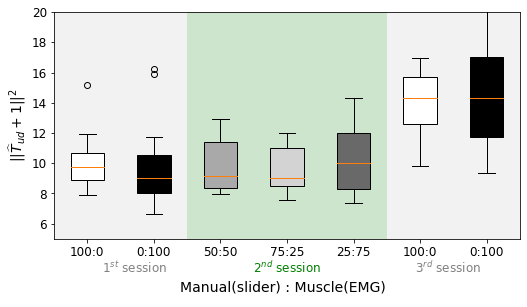

In [78]:
TUDvalues = TUD_NORM(last_trial,first_freq)

fig,axs = BOXPLOT(TUDvalues,'$||\widehat{T}_{ud}+1||^2$',ylimit0 = (5,20))#,ylimit0 = (0,13)
# fig.suptitle(plot_title)
plt.axvspan(0.5,2.5, facecolor='grey', alpha=0.1)
plt.axvspan(2.5,5.5, facecolor='green', alpha=0.2)
plt.axvspan(5.5,7.5, facecolor='grey', alpha=0.1)
plt.text(0.2,0.14, r'$1^{st}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.text(0.48,0.14, r'$2^{nd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'green')
plt.text(0.78,0.14, r'$3^{rd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.tight_layout()
plt.show()

In [192]:
w,pv,sig,flag = WilcoxonTest(TUDvalues)
flag


['there is significant difference between condition 0 and condition 4, w = 18.0, pvalue = 0.01507568359375',
 'there is significant difference between condition 0 and condition 5, w = 6.0, pvalue = 0.0008544921875',
 'there is significant difference between condition 0 and condition 6, w = 11.0, pvalue = 0.00335693359375',
 'there is significant difference between condition 1 and condition 6, w = 9.0, pvalue = 0.00201416015625',
 'there is significant difference between condition 2 and condition 5, w = 19.0, pvalue = 0.01806640625',
 'there is significant difference between condition 2 and condition 6, w = 12.0, pvalue = 0.0042724609375',
 'there is significant difference between condition 3 and condition 5, w = 25.0, pvalue = 0.04791259765625',
 'there is significant difference between condition 3 and condition 6, w = 13.0, pvalue = 0.00537109375']

In [95]:
w,pv,sig,flag = TTest(TUDvalues)
flag

['there is significant difference between condition 0 and condition 5, w = 3.976701229488659, pvalue = 0.0013776000835768296',
 'there is significant difference between condition 0 and condition 6, w = 3.020170014297319, pvalue = 0.009177097229994937',
 'there is significant difference between condition 1 and condition 5, w = 2.2740219373448647, pvalue = 0.03923339135642827',
 'there is significant difference between condition 1 and condition 6, w = 2.751444741712574, pvalue = 0.015600663676545194',
 'there is significant difference between condition 2 and condition 3, w = 2.1746002896175844, pvalue = 0.047295889376098736',
 'there is significant difference between condition 2 and condition 5, w = 4.868301768019756, pvalue = 0.00024859646790398256',
 'there is significant difference between condition 2 and condition 6, w = 3.7287490092026294, pvalue = 0.0022458285672097545',
 'there is significant difference between condition 3 and condition 5, w = 4.250957175650346, pvalue = 0.0008066

## |Ty(Md)|

In [79]:
def TYMD_NORM(last_trial,first_freq):

    # TFnorm: for every two trial for every participant (1 number for evry two trial)
    TFnorm = {}
    for p in range(participants_num): 
        TFnorm['subject'+str(p)] = {}
        for c in range(num_cond):  # then calculate TYR-1, normalize by freq^2
            # np.sum((np.abs(TF[TFtype]['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq])-1)**2,axis = 1)
            # TFnorm['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(TF['TUD']['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq]-1) *(1/M(stimulated_freq))*(1/stimulated_freq))**2,axis = 1 )
            TFnorm['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(TF['TYMD']['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq]) * amplitudes_output[first_freq])**2,axis = 1 )

        
    TFvalues = [] # 7 conditions x (15participants * i/2 trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(TFnorm['subject'+str(p)]['condition'+str(c)])) #average of all trials of a participant of a condition
        TFvalues.append(values_)

    return TFvalues #average MSE over all trials for every participant

In [122]:
last_trial = [4,4,4,4,4,4,4]

# what freqs to look at over all 8 stim freqs: (ex: [0,1,2,3,4,5,6,7])
first_freq = [0,1,2,3,4,5,6,7]
# first_freq = [0,1]
# first_freq = [2,3,4,5,6,7]

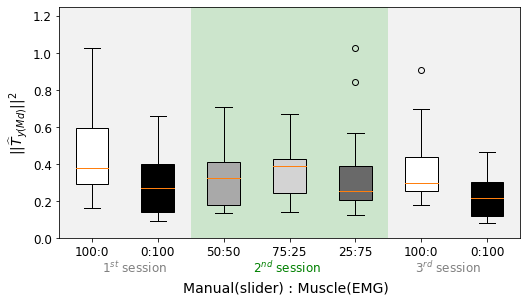

In [126]:
TYMDvalues = TYMD_NORM(last_trial,first_freq)

fig,axs = BOXPLOT(TYMDvalues,'$||\widehat{T}_{y(Md)}||^2$',ylimit0 = (0,1.25))#,ylimit0 = (0,13)
# fig.suptitle(plot_title)
plt.axvspan(0.5,2.5, facecolor='grey', alpha=0.1)
plt.axvspan(2.5,5.5, facecolor='green', alpha=0.2)
plt.axvspan(5.5,7.5, facecolor='grey', alpha=0.1)
plt.text(0.2,0.14, r'$1^{st}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.text(0.48,0.14, r'$2^{nd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'green')
plt.text(0.78,0.14, r'$3^{rd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.tight_layout()
plt.show()

In [125]:
w,pv,sig,flag = WilcoxonTest(TYMDvalues)
flag

['there is significant difference between condition 0 and condition 1, w = 0.0, pvalue = 6.103515625e-05',
 'there is significant difference between condition 0 and condition 2, w = 6.0, pvalue = 0.0008544921875',
 'there is significant difference between condition 0 and condition 4, w = 8.0, pvalue = 0.00152587890625',
 'there is significant difference between condition 0 and condition 5, w = 24.0, pvalue = 0.041259765625',
 'there is significant difference between condition 0 and condition 6, w = 15.0, pvalue = 0.00836181640625',
 'there is significant difference between condition 1 and condition 6, w = 23.0, pvalue = 0.03533935546875',
 'there is significant difference between condition 3 and condition 6, w = 18.0, pvalue = 0.01507568359375',
 'there is significant difference between condition 5 and condition 6, w = 19.0, pvalue = 0.01806640625']

## Tyr, Tud Bode

In [83]:
def PLOT_T_BODE(c, last_trial): 
    xlim = (stimulated_freq[0]-.01,stimulated_freq[-1]+.1)
    xticks = prime*0.05
    xticklabels =np.round(prime*0.05,2)
    # ylimmag = (1e-1,1.5e1)
    ylimmag = (1e-1,10**2)
    yticksmag = [0.1,1.0,10.0]
    yticklabelsmag = ['0.1','1.0','10.0']
    ylimphase = (-np.pi-0.1,np.pi+1.8)
    yticksphase = [-np.pi,0.,np.pi]
    yticklabelsphase = [r'$-\pi$',r'0',r'$+\pi$']

    # # plot
    # fig=plt.figure()
    # ax1 = plt.subplot(221)
    # ax2 = plt.subplot(222, sharey = ax1)
    # ax3 = plt.subplot(223)
    # ax4 = plt.subplot(224, sharey = ax3)

    fig,axs = plt.subplots(2, 2,sharex=True,figsize=(8,4))

    for j in [0,1]:
        if j==0:
            TType = 'TYR'
        else:
            TType = 'TUD'

        mag_mean = []
        phase_mean = []
        for p in range(participants_num):
            # mag & phase of all trials
            mag = np.abs(TF[TType]['subject'+str(p)]['condition'+str(c)][-(last_trial[c]//2):])
            phase = np.angle(TF[TType]['subject'+str(p)]['condition'+str(c)][-(last_trial[c]//2):])

            mag_mean.append( np.mean(mag,axis=0) ) #average of all trials
            phase_mean.append( np.angle( np.mean(np.exp(1j*phase), axis=0)) ) #average of all trials

        # average mag of all participants (15 numbers)
        mag_mean_mean = np.mean(mag_mean,axis=0)
        mag_mean_75 = np.percentile(mag_mean, 75, axis=0)
        mag_mean_25 = np.percentile(mag_mean, 25, axis=0)

        # average phase of all participants (15 numbers)
        if j==0:
            z = np.mean(np.exp(1j*(np.asarray(phase_mean))), axis=0)
            phase_mean_mean = np.angle(z)
            phase_mean_disp = 1-np.abs(z)
        else:
            z = np.mean(np.exp(1j*(np.asarray(phase_mean)-np.pi)), axis=0)
            phase_mean_mean = np.angle(z)+np.pi
            phase_mean_disp = 1-np.abs(z)

        ax = axs[0,j]
        # for i in range(math.ceil(trialnum[c]/2)):
        #     ax.plot(stimulated_freq, np.asarray(mag_mean)[i], '*--', color='0.8') 
        ax.plot(stimulated_freq, mag_mean_mean, 'o-', color=colors['d'])
        # ax.errorbar(x=stimulated_freq, y=mag_mean_mean, xerr=None,
        #             yerr=np.asarray([mag_mean_mean-mag_mean_25, mag_mean_75-mag_mean_mean]),
        #             color='k',ls='none',zorder=10)
        ax.fill_between(stimulated_freq, mag_mean_25, mag_mean_75,
                                facecolor=colors['d'],edgecolor=colors['d'],alpha = 0.3)
        # ax.plot(xlim,[0.,0.],'k--',zorder=-1)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_xlim(xlim)
        ax.set_ylim(ylimmag)
        ax.set_yticks(yticksmag) 
        ax.set_yticklabels(yticklabelsmag,**font)
        # ax.title.set_text()
        ax.grid('on',zorder=-1)

        ax = axs[1,j]
        # for i in range(math.ceil(trialnum[c]/2)):
        #     ax.plot(stimulated_freq, phase_mean[i], '*--', color='0.8') 
        ax.plot(stimulated_freq, phase_mean_mean, 'o-', color=colors['d'],label=TType)
        # ax.errorbar(x=stimulated_freq, y=phase_mean_mean, xerr=None,
        #             yerr=np.asarray([phase_mean_disp, phase_mean_disp]),
        #             color='k',ls='none',zorder=10)
        ax.fill_between(stimulated_freq, phase_mean_mean+phase_mean_disp,phase_mean_mean-phase_mean_disp,
                                facecolor=colors['d'],edgecolor=colors['d'],alpha = 0.3)
        
        # ax.plot(xlim,[np.pi,np.pi],'k--',zorder=-1,alpha = 0.5)
        ax.set_xscale("log")
        ax.set_xlim(xlim)
        ax.set_ylim(ylimphase)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels,rotation=90)
        ax.set_yticks(yticksphase) 
        ax.set_yticklabels(yticklabelsphase,**font)
        ax.grid('on',zorder=-1)
        

    ax = axs[0,0]
    ax.set_ylabel('gain')

    ax = axs[1,0]
    ax.set_ylabel('phase (raidans)')
    ax.legend(loc='lower center',ncol=2,frameon=False)

    ax = axs[0,1]
    # ax.plot(stimulated_freq,np.abs(1/M_h[stimulated_index]), 'o-', color='black') # M^-1
    # ax = axs[1,1]
    # ax.plot(stimulated_freq,np.angle(1/M_h[stimulated_index]), 'o-', color='black',label=r'$M^{-1}$') # M^-1
    ax.legend(loc='lower center',ncol=2,frameon=False)

    plt.tight_layout()
    fig.suptitle('condition '+str(c)) 
    plt.show()



No handles with labels found to put in legend.


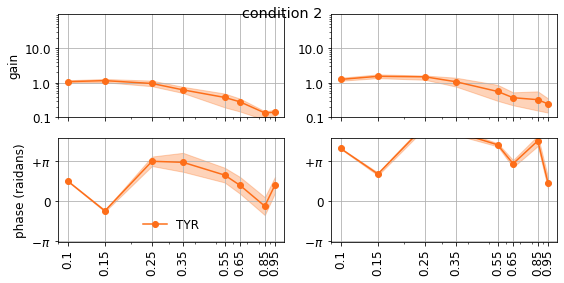

In [86]:
PLOT_T_BODE(2,last_trial)

No handles with labels found to put in legend.


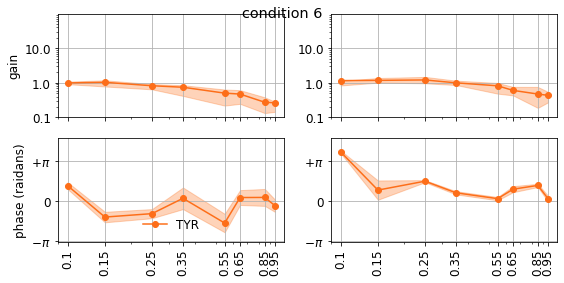

In [85]:
PLOT_T_BODE(6,last_trial)

# UX all non-stim freq

In [33]:
#mask for index of freq that are less than 1Hz
def lessthanone(x): return x <= 1.0
indexone = [idx for idx, element in enumerate(xf) if lessthanone(element)]
unwanted_index = {4,  6, 10, 14, 22, 26, 34, 38}
nonstimulated_index = [i for i in indexone if i not in unwanted_index]
all_nonstimulated_index = [i for i in range(N//2) if i not in unwanted_index]
last_trial = [4,4,4,4,4,4,4]

In [34]:
# UX below corssover
UXnorm = {}
for p in range(participants_num): 
    UXnorm['subject'+str(p)] = {}
    for c in range(num_cond): 
        UX_all = np.abs(np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U'][-last_trial[c]:])[:,all_nonstimulated_index]) #average UX of all trials 
        UXnorm['subject'+str(p)]['condition'+str(c)] = (LA.norm(UX_all,axis = 1))**2

UXvalues = [] # 7 conditions x (15participants * i/2 trials)
for c in range(num_cond):
    values_ = []
    for p in range(participants_num):
        values_.append(np.mean(UXnorm['subject'+str(p)]['condition'+str(c)])) #average of all trials of a participant of a condition
    UXvalues.append(values_) #each participant 

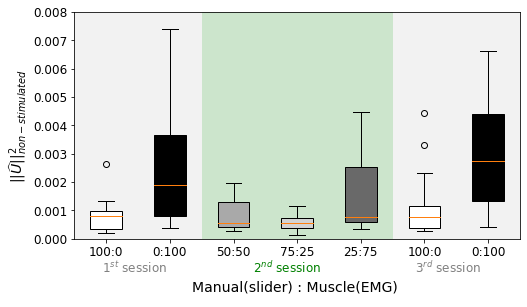

In [40]:
fig,axs = BOXPLOT(UXvalues,r'$||\widehat{U}||^2_{non-stimulated}$',ylimit0=(0.,0.008))
# fig.suptitle('non-stim UX below corssover')
plt.axvspan(0.5,2.5, facecolor='grey', alpha=0.1)
plt.axvspan(2.5,5.5, facecolor='green', alpha=0.2)
plt.axvspan(5.5,7.5, facecolor='grey', alpha=0.1)
plt.text(0.2,0.14, r'$1^{st}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.text(0.48,0.14, r'$2^{nd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'green')
plt.text(0.78,0.14, r'$3^{rd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.tight_layout()
plt.show()

In [41]:
w,pv,sig,flag = WilcoxonTest(UXvalues)
flag

['there is significant difference between condition 0 and condition 1, w = 1.0, pvalue = 0.0001220703125',
 'there is significant difference between condition 0 and condition 6, w = 0.0, pvalue = 6.103515625e-05',
 'there is significant difference between condition 1 and condition 2, w = 6.0, pvalue = 0.0008544921875',
 'there is significant difference between condition 1 and condition 3, w = 3.0, pvalue = 0.00030517578125',
 'there is significant difference between condition 2 and condition 3, w = 15.0, pvalue = 0.00836181640625',
 'there is significant difference between condition 2 and condition 4, w = 25.0, pvalue = 0.04791259765625',
 'there is significant difference between condition 2 and condition 6, w = 0.0, pvalue = 6.103515625e-05',
 'there is significant difference between condition 3 and condition 4, w = 11.0, pvalue = 0.00335693359375',
 'there is significant difference between condition 3 and condition 5, w = 25.0, pvalue = 0.04791259765625',
 'there is significant diffe

# UX below 1 Hz

In [91]:
#mask for index of freq that are less than 1Hz
def lessthanone(x): return x <= 1.0
indexone = [idx for idx, element in enumerate(xf) if lessthanone(element)]
unwanted_index = {4,  6, 10, 14, 22, 26, 34, 38}
nonstimulated_index = [i for i in indexone if i not in unwanted_index]
all_nonstimulated_index = [i for i in range(N//2) if i not in unwanted_index]
last_trial = [4,4,4,4,4,4,4]

In [92]:
UXvalues = [] # 7 conditions x (15participants * i/2 trials)
for c in range(num_cond):
    values_ = []
    for p in range(participants_num):
        U_less1 = np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['UX'][-last_trial[c]:])
        values_.append( np.mean((LA.norm(U_less1,axis =1))**2) ) #norm of each trial, then take the average for all trials
    UXvalues.append(values_)

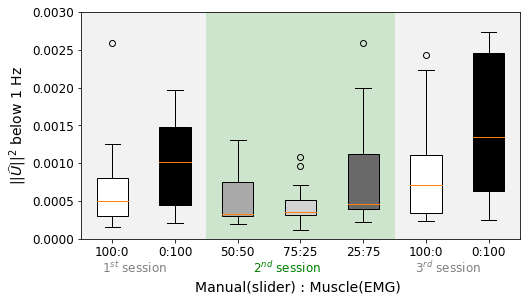

In [93]:
fig,axs = BOXPLOT(UXvalues,r'$||\widehat{U}||^2$ below 1 Hz',ylimit0=(0.00,0.003))
# fig.suptitle('non-stim UX below corssover')
plt.axvspan(0.5,2.5, facecolor='grey', alpha=0.1)
plt.axvspan(2.5,5.5, facecolor='green', alpha=0.2)
plt.axvspan(5.5,7.5, facecolor='grey', alpha=0.1)
plt.text(0.2,0.14, r'$1^{st}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.text(0.48,0.14, r'$2^{nd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'green')
plt.text(0.78,0.14, r'$3^{rd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.tight_layout()
plt.show()

In [94]:
w,pv,sig,flag = WilcoxonTest(UXvalues)
flag

['there is significant difference between condition 0 and condition 6, w = 5.0, pvalue = 0.0006103515625',
 'there is significant difference between condition 1 and condition 2, w = 13.0, pvalue = 0.00537109375',
 'there is significant difference between condition 1 and condition 3, w = 13.0, pvalue = 0.00537109375',
 'there is significant difference between condition 2 and condition 5, w = 25.0, pvalue = 0.04791259765625',
 'there is significant difference between condition 2 and condition 6, w = 3.0, pvalue = 0.00030517578125',
 'there is significant difference between condition 3 and condition 4, w = 22.0, pvalue = 0.0301513671875',
 'there is significant difference between condition 3 and condition 5, w = 17.0, pvalue = 0.012451171875',
 'there is significant difference between condition 3 and condition 6, w = 0.0, pvalue = 6.103515625e-05',
 'there is significant difference between condition 4 and condition 6, w = 19.0, pvalue = 0.01806640625']

# Delta

In [16]:
delta_file = open("AvgDelta.pkl", "rb") #remember to close afterwards
avgdelta = pickle.load(delta_file)
delta_file.close()

In [17]:
# Delta = {}
# for p in range(participants_num): 
#     Delta['subject'+str(p)] = {}
#     for c in range(num_cond): 
#         UX_all = np.abs(np.asarray(avgdelta['avgdelta_mag']['subject'+str(p)]['condition'+str(c)])) #average UX of all trials 
#         Delta['subject'+str(p)]['condition'+str(c)] = LA.norm(UX_all,axis = 1)

Deltavalues = [] # 7 conditions x (15participants * i/2 trials)
for c in range(num_cond):
    values_ = []
    for p in range(participants_num):
        delta = avgdelta['avgdelta_mag']['subject'+str(p)]['condition'+str(c)].copy()
        delta[0] = 0
        values_.append(LA.norm(delta)) #average of all trials of a participant of a condition
    Deltavalues.append(values_) #each participant 

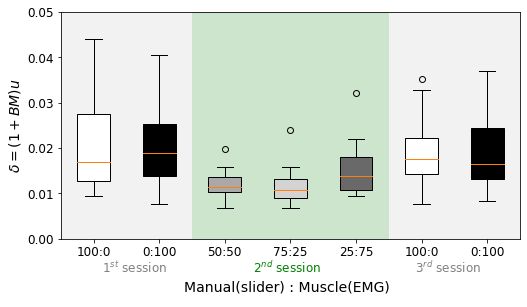

In [18]:
fig,axs = BOXPLOT(Deltavalues,r'$\delta = (1+BM)u$',ylimit0 = (0,0.05))
# fig.suptitle('non-stim UX below corssover')
plt.axvspan(0.5,2.5, facecolor='grey', alpha=0.1)
plt.axvspan(2.5,5.5, facecolor='green', alpha=0.2)
plt.axvspan(5.5,7.5, facecolor='grey', alpha=0.1)
plt.text(0.2,0.14, r'$1^{st}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.text(0.48,0.14, r'$2^{nd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'green')
plt.text(0.78,0.14, r'$3^{rd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.tight_layout()
plt.show()

In [19]:
w,pv,sig,flag = WilcoxonTest(Deltavalues)
flag

['there is significant difference between condition 0 and condition 2, w = 6.0, pvalue = 0.0008544921875',
 'there is significant difference between condition 0 and condition 3, w = 3.0, pvalue = 0.00030517578125',
 'there is significant difference between condition 1 and condition 2, w = 7.0, pvalue = 0.00115966796875',
 'there is significant difference between condition 1 and condition 3, w = 11.0, pvalue = 0.00335693359375',
 'there is significant difference between condition 2 and condition 4, w = 13.0, pvalue = 0.00537109375',
 'there is significant difference between condition 2 and condition 5, w = 16.0, pvalue = 0.01025390625',
 'there is significant difference between condition 2 and condition 6, w = 7.0, pvalue = 0.00115966796875',
 'there is significant difference between condition 3 and condition 4, w = 23.0, pvalue = 0.03533935546875',
 'there is significant difference between condition 3 and condition 5, w = 13.0, pvalue = 0.00537109375',
 'there is significant difference

# Delta below crossover

In [27]:
Deltavalues_below = [] # 7 conditions x (15participants * i/2 trials)
for c in range(num_cond):
    values_ = []
    for p in range(participants_num):
        delta = avgdelta['avgdelta_mag']['subject'+str(p)]['condition'+str(c)][:10].copy()
        delta[0] = 0
        values_.append(LA.norm(delta)) #average of all trials of a participant of a condition
    Deltavalues_below.append(values_) #each participant 

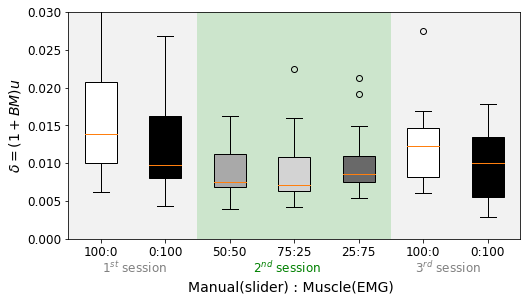

In [28]:
fig,axs = BOXPLOT(Deltavalues_below,r'$\delta = (1+BM)u$',ylimit0 = (0,0.03))
# fig.suptitle('non-stim UX below corssover')
plt.axvspan(0.5,2.5, facecolor='grey', alpha=0.1)
plt.axvspan(2.5,5.5, facecolor='green', alpha=0.2)
plt.axvspan(5.5,7.5, facecolor='grey', alpha=0.1)
plt.text(0.2,0.14, r'$1^{st}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.text(0.48,0.14, r'$2^{nd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'green')
plt.text(0.78,0.14, r'$3^{rd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.tight_layout()
plt.show()

In [29]:
w,pv,sig,flag = WilcoxonTest(Deltavalues_below)
flag

['there is significant difference between condition 0 and condition 2, w = 10.0, pvalue = 0.00262451171875',
 'there is significant difference between condition 0 and condition 3, w = 1.0, pvalue = 0.0001220703125',
 'there is significant difference between condition 0 and condition 4, w = 24.0, pvalue = 0.041259765625',
 'there is significant difference between condition 0 and condition 5, w = 21.0, pvalue = 0.02557373046875',
 'there is significant difference between condition 1 and condition 2, w = 21.0, pvalue = 0.02557373046875',
 'there is significant difference between condition 1 and condition 3, w = 23.0, pvalue = 0.03533935546875',
 'there is significant difference between condition 3 and condition 5, w = 24.0, pvalue = 0.041259765625']

## Delta above crossover

In [43]:
Deltavalues_above = [] # 7 conditions x (15participants * i/2 trials)
for c in range(num_cond):
    values_ = []
    for p in range(participants_num):
        delta = avgdelta['avgdelta_mag']['subject'+str(p)]['condition'+str(c)][11:].copy()
        delta[0] = 0
        values_.append(LA.norm(delta)) #average of all trials of a participant of a condition
    Deltavalues_above.append(values_) #each participant 

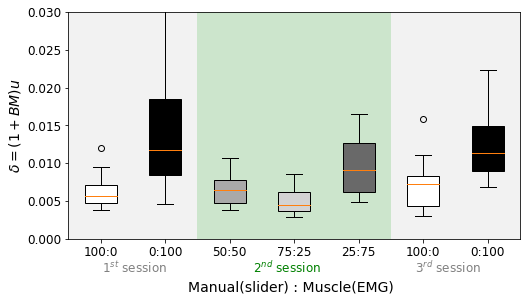

In [44]:
fig,axs = BOXPLOT(Deltavalues_above,r'$\delta = (1+BM)u$',ylimit0 = (0,0.03))
# fig.suptitle('non-stim UX below corssover')
plt.axvspan(0.5,2.5, facecolor='grey', alpha=0.1)
plt.axvspan(2.5,5.5, facecolor='green', alpha=0.2)
plt.axvspan(5.5,7.5, facecolor='grey', alpha=0.1)
plt.text(0.2,0.14, r'$1^{st}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.text(0.48,0.14, r'$2^{nd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'green')
plt.text(0.78,0.14, r'$3^{rd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.tight_layout()
plt.show()

In [45]:
w,pv,sig,flag = WilcoxonTest(Deltavalues_above)
flag

['there is significant difference between condition 0 and condition 1, w = 2.0, pvalue = 0.00018310546875',
 'there is significant difference between condition 0 and condition 4, w = 10.0, pvalue = 0.00262451171875',
 'there is significant difference between condition 0 and condition 6, w = 0.0, pvalue = 6.103515625e-05',
 'there is significant difference between condition 1 and condition 2, w = 2.0, pvalue = 0.00018310546875',
 'there is significant difference between condition 1 and condition 3, w = 0.0, pvalue = 6.103515625e-05',
 'there is significant difference between condition 1 and condition 5, w = 20.0, pvalue = 0.02154541015625',
 'there is significant difference between condition 2 and condition 3, w = 11.0, pvalue = 0.00335693359375',
 'there is significant difference between condition 2 and condition 4, w = 0.0, pvalue = 6.103515625e-05',
 'there is significant difference between condition 2 and condition 6, w = 0.0, pvalue = 6.103515625e-05',
 'there is significant differ